# Load Processed Data

Loads and combines the image features with the padded sequences into a Tensorflow dataset.

## Setup and Imports

In [1]:
# Confirm environment
!conda info


     active environment : /courses/IE7374.202550/shared/genai-gpu
    active env location : /courses/IE7374.202550/shared/genai-gpu
            shell level : 1
       user config file : /home/ubhad.a/.condarc
 populated config files : 
          conda version : 24.5.0
    conda-build version : 24.5.1
         python version : 3.12.4.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=broadwell
                          __conda=24.5.0=0
                          __cuda=12.3=0
                          __glibc=2.34=0
                          __linux=5.14.0=0
                          __unix=0=0
       base environment : /shared/EL9/explorer/anaconda3/2024.06  (read only)
      conda av data dir : /shared/EL9/explorer/anaconda3/2024.06/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

# Add ../src to the Python path so `vtt` can be found
sys.path.append(os.path.abspath("../src"))

from vtt.utils import detect_and_set_device


2025-07-13 19:39:09.507177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752449949.540819 1272267 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752449949.551308 1272267 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752449949.576587 1272267 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752449949.576607 1272267 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752449949.576611 1272267 computation_placer.cc:177] computation placer alr

In [4]:
import numpy as np
from tensorflow.keras.layers import Lambda

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from vtt.utils import detect_and_set_device

In [5]:
# Detect and set up GPU or use CPU
#device_used = detect_and_set_device()
#print(f"TensorFlow is configured to use: {device_used}")

## Combine Features and Sequences

In [6]:
def load_features_and_sequences_for_decoder(
    features_path: str,
    captions_path: str,
    batch_size: int = 32,
    shuffle: bool = True,
    buffer_size: int = 1000
) -> tf.data.Dataset:
    features_npz = np.load(features_path)
    captions_npz = np.load(captions_path, allow_pickle=True)

    image_features = []
    caption_inputs = []
    caption_targets = []

    for img_id in captions_npz.files:
        if img_id not in features_npz:
            continue

        feature = features_npz[img_id]
        captions = captions_npz[img_id]

        for caption in captions:
            # caption = [start, ..., end] => input = [start, ..., end-1], target = [1, ..., end]
            caption = np.array(caption)
            caption_input = caption[:-1]
            caption_target = caption[1:]

            image_features.append(feature)
            caption_inputs.append(caption_input)
            caption_targets.append(caption_target)

    # Pad again in case they're uneven
    caption_inputs = pad_sequences(caption_inputs, padding="post")
    caption_targets = pad_sequences(caption_targets, padding="post")

    image_features = tf.convert_to_tensor(image_features, dtype=tf.float32)
    caption_inputs = tf.convert_to_tensor(caption_inputs, dtype=tf.int32)
    caption_targets = tf.convert_to_tensor(caption_targets, dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices(((image_features, caption_inputs), caption_targets))

    if shuffle:
        dataset = dataset.shuffle(buffer_size)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [7]:
image_features = "../data/processed/flickr8k_features.npz"
padded_sequences = "../data/processed/flickr8k_padded_caption_sequences.npz"
#dataset = load_features_and_sequences_for_decoder(image_features, padded_sequences)

In [8]:
###Experiment 

In [9]:
def load_features_and_sequences_for_decoder(
    features_path: str,
    captions_path: str,
    batch_size: int = 32,
    shuffle: bool = True,
    buffer_size: int = 1000
) -> tf.data.Dataset:
    features_npz = np.load(features_path)
    captions_npz = np.load(captions_path, allow_pickle=True)

    image_features = []
    caption_inputs = []
    caption_targets = []

    for img_id in captions_npz.files:
        if img_id not in features_npz:
            continue

        feature = features_npz[img_id]
        captions = captions_npz[img_id]

        for caption in captions:
            # caption = [start, ..., end] => input = [start, ..., end-1], target = [1, ..., end]
            caption = np.array(caption)
            caption_input = caption[:-1]
            caption_target = caption[1:]

            image_features.append(feature)
            caption_inputs.append(caption_input)
            caption_targets.append(caption_target)

    # Pad again in case they're uneven
    caption_inputs = pad_sequences(caption_inputs, padding="post")
    caption_targets = pad_sequences(caption_targets, padding="post")

    image_features = tf.convert_to_tensor(image_features, dtype=tf.float32)
    caption_inputs = tf.convert_to_tensor(caption_inputs, dtype=tf.int32)
    caption_targets = tf.convert_to_tensor(caption_targets, dtype=tf.int32)

    dataset = tf.data.Dataset.from_tensor_slices(((image_features, caption_inputs), caption_targets))

    if shuffle:
        dataset = dataset.shuffle(buffer_size)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [10]:
import pickle

with open("../data/processed/flickr8k_tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)


In [11]:
## Decoder Model (LSTM-based)

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Concatenate, Lambda

def build_decoder_model(vocab_size, max_caption_len, embedding_dim=256, lstm_units=512):
    # Image features input (2048)
    img_input = Input(shape=(2048,), name="image_input")
    img_emb = Dense(embedding_dim, activation="relu")(img_input)
    img_emb = Lambda(lambda x: tf.expand_dims(x, 1))(img_emb)  # (None, 1, embedding_dim)

    # Caption input
    caption_input = Input(shape=(max_caption_len,), name="caption_input")
    caption_emb = Embedding(vocab_size, embedding_dim, mask_zero=False)(caption_input)

    # Concatenate along time dimension
    merged = Concatenate(axis=1)([img_emb, caption_emb])

    # LSTM
    lstm_out = LSTM(lstm_units, return_sequences=True)(merged)

    # Final output
    output = Dense(vocab_size, activation='softmax')(lstm_out)
    output = Lambda(lambda x: x[:, 1:, :])(output) #output shape becomes (None, max_caption_len, vocab_size)matching caption_targets.


    model = Model(inputs=[img_input, caption_input], outputs=output)
    #model.compile(loss='sparse_categorical_crossentropy',  optimizer=keras.optimizers.Adam(learning_rate=1e-4))
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
    return model


In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


dataset = load_features_and_sequences_for_decoder(
    features_path="../data/processed/flickr8k_features.npz",
    captions_path="../data/processed/flickr8k_padded_caption_sequences.npz",
    batch_size=64)

# Get max_caption_len from input shape
for (img_feat, cap_in), cap_out in dataset.take(1):
    max_caption_len = cap_in.shape[1]

model = build_decoder_model(vocab_size=tokenizer.num_words, max_caption_len=max_caption_len)
model.summary()

# Train
history = model.fit(dataset, epochs=18)


W0000 00:00:1752449968.608981 1272267 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-07-13 19:39:34.030118: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ caption_input       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 18, 256)   │  2,560,000 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 19, 256)   │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 19, 512)   │  1,574,912 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 19, 10000) │  5,130,000 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 18, 10000) │          0 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,789,456 (37.34 MB)

 Trainable params: 9,789,456 (37.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 230s 384ms/step - loss: 3.4793
Epoch 2/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 228s 384ms/step - loss: 2.2102
Epoch 3/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 228s 383ms/step - loss: 2.0142
Epoch 4/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 233s 392ms/step - loss: 1.9057
Epoch 5/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 233s 392ms/step - loss: 1.8231
Epoch 6/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 233s 392ms/step - loss: 1.7567
Epoch 7/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 231s 389ms/step - loss: 1.6975
Epoch 8/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 231s 389ms/step - loss: 1.6409
Epoch 9/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 232s 390ms/step - loss: 1.5864
Epoch 10/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 232s 390ms/step - loss: 1.5340
Epoch 11/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 229s 386ms/step - loss: 1.4816
Epoch 12/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 232s 390ms/step - loss: 1.4301
Epoch 13/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 231s 389ms/step - loss: 1.3788
Epoch 14/18
594/594 ━━━━━━━━━━━━━━━━━━━━ 234s 393ms/step - loss: 1.3304
E

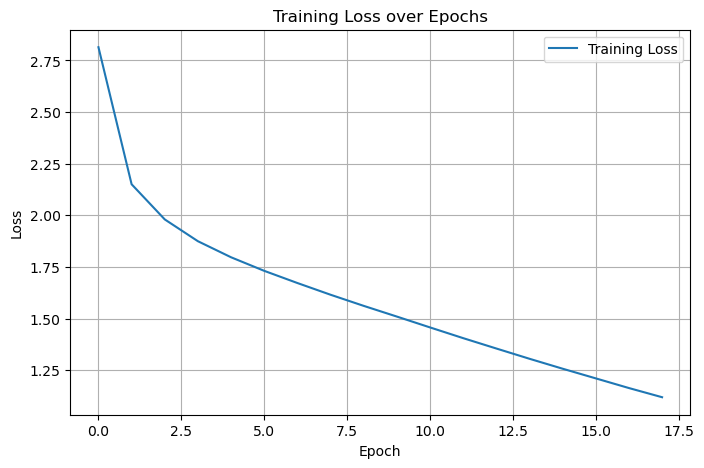

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# caption generation

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_caption_greedy(model, tokenizer, image_feature, max_len=None):
    """
    Generate a caption using greedy decoding.

    Args:
        model (tf.keras.Model): Trained captioning model.
        tokenizer (Tokenizer): Fitted tokenizer with <start> and <end> tokens.
        image_feature (np.array): Precomputed image embedding of shape (2048,).
        max_len (int, optional): Max caption length. If None, inferred from model.

    Returns:
        str: Generated caption (without <start>/<end> tokens).
    """
    # Infer max_len if not provided
    if max_len is None:
        max_len = model.input[1].shape[1]  # caption_input layer shape

    # Get special tokens
    start_token = tokenizer.word_index.get("startseq")
    end_token = tokenizer.word_index.get("endseq")

    if start_token is None or end_token is None:
        raise ValueError("Tokenizer must contain <startseq> and <endseq> tokens.")

    # Initialize sequence with <start>
    caption_seq = [start_token]

    for _ in range(max_len):
        # Pad the current sequence
        padded_seq = pad_sequences([caption_seq], maxlen=max_len, padding='post')

        # Predict the next word
        preds = model.predict([np.expand_dims(image_feature, axis=0), padded_seq], verbose=0)
        next_word_id = np.argmax(preds[0, len(caption_seq)-1, :])

        # Append and stop if <end> is predicted
        caption_seq.append(next_word_id)
        if next_word_id == end_token:
            break

    # Convert word indices to tokens
    index_word = tokenizer.index_word
    words = [index_word.get(i, '') for i in caption_seq[1:] if i != end_token]
    return ' '.join(words).strip()


In [20]:
def display_images_with_captions(image_ids, model, tokenizer, features, image_folder):
    for image_id in image_ids:
        try:
            image_feature = features[image_id]
            caption = generate_caption_greedy(model, tokenizer, image_feature)
            image_path = f"{image_folder}/{image_id}"

            img = Image.open(image_path)
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.axis("off")
            plt.title(caption, fontsize=12)
            plt.show()

        except Exception as e:
            print(f"Error processing image {image_id}: {e}")

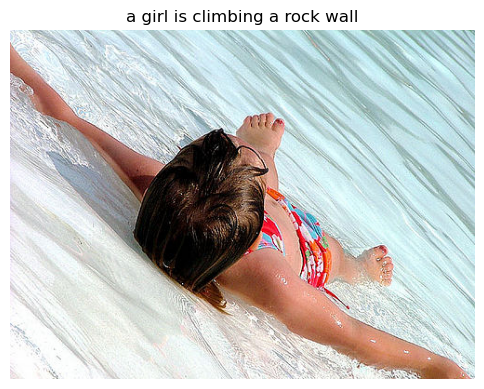

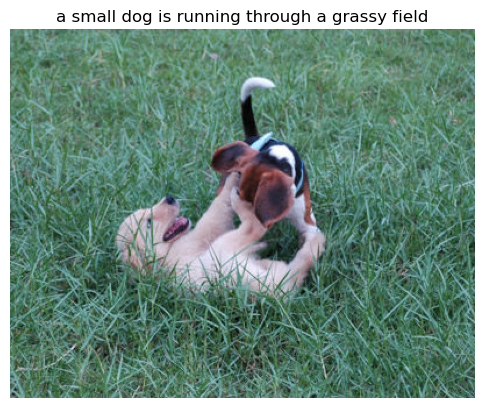

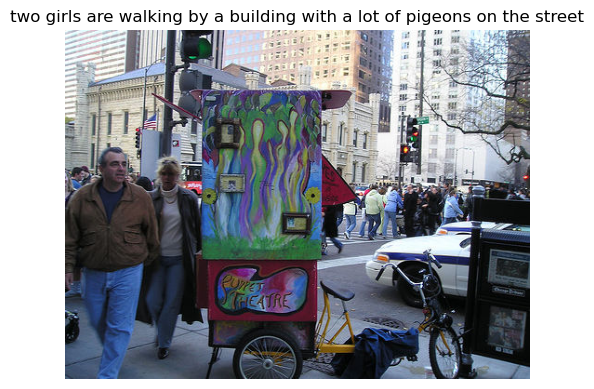

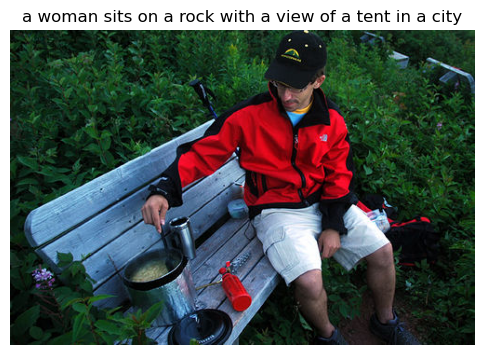

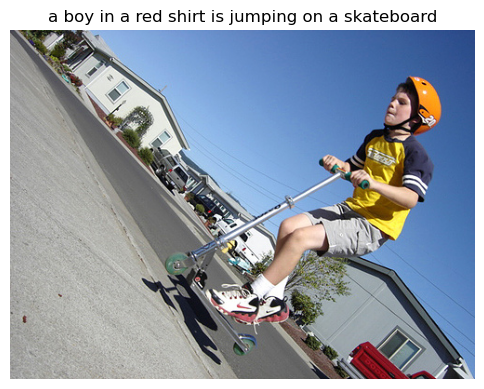

In [21]:
from PIL import Image

features = np.load("../data/processed/flickr8k_features.npz")
image_ids =[ "667626_18933d713e.jpg", "23445819_3a458716c1.jpg", "27782020_4dab210360.jpg" ,
             "35506150_cbdb630f4f.jpg", "47870024_73a4481f7d.jpg"]

#image_feature = features[image_id]

display_images_with_captions(image_ids=image_ids,
    model=model,
    tokenizer=tokenizer,
    features=features,
    image_folder="../data/flickr8k_images_dataset/Images")

